# YouTube Machine Learning Model
###### Created by Randhir and Andrew

Model that will take a $90\times120$ thumbnail JPEG and title from YouTube to output a video performance metric.
The metric will be 
$$Score=\log{(View\ Count + 1)}$$
The idea is that the video that attracted more views is a good video. The value is log-scaled as the higher the view count, the less meaningful it becomes. This value will be normalized with the maximum value in the dataset.

#### Imports
This cell contains all the necessary imports of the model.

In [1]:
import string, requests, os, json, random, math, re
import urllib.request
import urllib.error
from pathlib import Path

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tf_keras.backend import clear_session
from tf_keras.callbacks import ModelCheckpoint, EarlyStopping
from tf_keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Concatenate, Input
from tf_keras.optimizers import Adam
from tf_keras.utils import Sequence, plot_model
from tf_keras import Model
from sklearn.model_selection import KFold
from transformers import TFBertModel, BertTokenizer

import nltk
from nltk.corpus import stopwords

from dotenv import load_dotenv

# Load .env file with your api key
if not load_dotenv():
	print(".env file not found")

2024-11-28 09:43:19.620158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732804999.683939     578 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732804999.702661     578 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 09:43:19.869108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/chairmanpooh/YT-ML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update 

#### Constants
This cell contains the constants used by this model

In [ ]:
# File Structure
dirpath = "thumbnail"
modeldir = "models"
datafile = "videos_df.parquet"

# Data Aquisition
filepath = "data.csv"
topic_id = "/m/03hf_rm" # Strategy Games
API_KEY = os.getenv("APIKEY")

# Data Filtering
filepath_final = "data-filtered.csv"
lang = "en"

# Labeling
MAX_VIEWS = 15.3e9 # Baby Shark Video (Most Viewed Video)
MAX_SUBS = 3.5e8 # MrBeast 
THRESHOLD = 0.025

# Regex Patterns
emoji_re = "[\U000000A9-\U0010ffff]"
punc_re = f"[{re.escape(string.punctuation)}]"
space_re = "\s{1,}"

# Download Stopwords & pattern
nltk.download('stopwords')
stopwords_list = stopwords.words("english")
sw_re = f'\b(?:{"|".join([f"{re.escape(sw)}" for sw in stopwords_list])})\b'

# Vectorization
vectorizator_model = "bert-base-uncased"
bert_tokenizer : BertTokenizer = BertTokenizer.from_pretrained(vectorizator_model)
bert_model : TFBertModel = TFBertModel.from_pretrained(vectorizator_model)
bert_model.trainable = False

# KFold Settings
n_folds = 5
epochs = 10
batch_size = 32
learning_rate = 1e-3

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chairmanpooh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
I0000 00:00:1732766565.603938     452 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initiali

#### Data Aquisition
The YouTube API is used to get video data. This includes a video's thumbnail and metrics.

In [7]:
def query_data(APIKEY : str, topic_filter : str, filedest : str="", query_attempts : int=100, video_count : int=50, lang_filter : str="en", verbose : bool=True) -> pd.DataFrame:
    """
    Data Query Function

    Params
    ======
    APIKEY: Key to the YouTube API
    topic_filter: Topic ID per the YouTube API documentation
    filedest: Location of file to save to; empty string means no file creation or saving; if file exists, will read all data into memory
    query_attempts: Number of times to query the API
    video_count: Number of videos to retrieve from the API per call; maximum value of 50
    lang_filter: language filter for videos; this is not 100% effective

    Returns
    =======
    Dataframe with retrieved data with the following columns:
    ["yt-id", "title", "created", "channel-id", "thumbnail", "thumbnail-w", "thumbnail-h", "view-count", "like-count", "comment-count", "query"]
    """
    # Check if data file already exist
    if filedest != "" and os.path.isfile(filedest):
        df = pd.read_csv(filedest, index_col="yt-id")
    else:
        df = pd.DataFrame([], columns=["yt-id", "title", "created", "channel-id", "thumbnail", "thumbnail-w", "thumbnail-h", "view-count", "like-count", "comment-count", "query"])
        df = df.set_index("yt-id")
        
    # Grab missing data IDs for query
    yt_ids = list(df[df["view-count"].isna()].index)

    # Loop
    yt_reads = 0
    for i in range(query_attempts):
        try:
            # Message
            if verbose:
                print(f"Pulling {video_count} random videos")

            # Generates random query for YT
            r_q = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(3))

            # Calls the API for search results (100 units)
            urlData_query = f"https://www.googleapis.com/youtube/v3/search?key={APIKEY}&maxResults={video_count}&part=snippet&type=video&relevanceLanguage={lang_filter}&topicId={topic_filter}&q={r_q}"
            webURL_query = urllib.request.urlopen(urlData_query)
            raw_vid_data = webURL_query.read()
            results_vids = json.loads(raw_vid_data.decode(webURL_query.info().get_content_charset('utf-8')))

            # Process Video Response
            for video_data in results_vids['items']:
                # Ignore Live and Upcoming Content (no ratings yet)
                if video_data['snippet']['liveBroadcastContent'] != "none":
                    continue

                # Parse data
                try:
                    new_row = pd.DataFrame([{
                        "yt-id": video_data['id']['videoId'],
                        "title": video_data['snippet']['title'],
                        "created": video_data['snippet']['publishedAt'],
                        "channel-id": video_data['snippet']['channelId'],
                        "thumbnail": video_data['snippet']['thumbnails']["default"]["url"],
                        "thumbnail-w": video_data['snippet']['thumbnails']["default"]["width"],
                        "thumbnail-h": video_data['snippet']['thumbnails']["default"]["height"],
                        "query": r_q,
                    },])
                    new_row = new_row.set_index("yt-id")

                    try:
                        # Append
                        df = pd.concat([df, new_row], verify_integrity=True)

                        # Store your ids
                        yt_reads += 1

                        # Prepare id for stats query
                        yt_ids.append(video_data['id']['videoId'])
                    except ValueError:
                        # Duplicate video detected
                        continue
                except KeyError:
                    # Weird Entry
                    continue

            # Update User
            if verbose:
                print(f"API call #{i + 1} successfully")
                
            # Check if any stats calls are needed
            if len(yt_ids) > 0:
                # Message 
                if verbose:
                    print("Pulling statistics for missing data values")

                # Split up batch by 50 due to GET limits
                for batched_ids in np.array_split(yt_ids, math.ceil(len(yt_ids) / 50)):
                    # Generate & call statistic query (1 unit)
                    urlData_stats = f"https://www.googleapis.com/youtube/v3/videos?key={APIKEY}&part=statistics&id={','.join(batched_ids)}"
                    webURL_stats = urllib.request.urlopen(urlData_stats)
                    raw_stats_data = webURL_stats.read()
                    results_stats = json.loads(raw_stats_data.decode(webURL_stats.info().get_content_charset('utf-8')))

                    # Process Stats Response
                    for stats_data in results_stats["items"]:
                        try:
                            # Parse data
                            new_row = pd.DataFrame([{
                                "yt-id": stats_data['id'],
                                "view-count": stats_data['statistics']['viewCount'],
                                "like-count": stats_data['statistics']['likeCount'] if 'likeCount' in stats_data['statistics'] else "",
                                "comment-count": stats_data['statistics']['commentCount'] if 'commentCount' in stats_data['statistics'] else "",
                            },])
                            new_row = new_row.set_index("yt-id")

                            # Update main dataset
                            df.update(new_row)
                        except KeyError:
                            # Weird Entry
                            continue

                # Reset after used
                yt_ids = [] 

                # Message
                if verbose: 
                    print("Finished pulling statistics for current batch")

            # Dumb Data to prevent loss every 5 runs
            if filedest != "" and i % 5 == 0:
                df.to_csv(filedest)

        # ON API failure, quit and save
        except urllib.error.HTTPError:
            if verbose:
                print("Latest API call failed. You are likely out of units. Try again tomorrow.")
            break
        
    # Write to csv
    if filedest != "":
        df.to_csv(filedest)

    # Termination
    if verbose:
        print(f"Was able to pull {yt_reads} rows")

    # Return
    return df

In [ ]:
query_data(API_KEY, topic_id, filepath, 1)

Pulling 50 random videos
API call #1 successfully
Pulling statistics for missing data values


C:\Users\andre\AppData\Local\Temp\ipykernel_12456\532892778.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1692.0 4280.0 7087.0 ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.update(new_row)
C:\Users\andre\AppData\Local\Temp\ipykernel_12456\532892778.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[72.0 147.0 157.0 ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.update(new_row)
C:\Users\andre\AppData\Local\Temp\ipykernel_12456\532892778.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19.0 18.0 33.0 ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.update(new_row)


Finished pulling statistics for current batch
Was able to pull 46 rows


,title,created,channel-id,thumbnail,thumbnail-w,thumbnail-h,view-count,like-count,comment-count,query
yt-id,,,,,,,,,,
ODPTe6U-iEM,Обзор MKA гайд легкий танк Германии | mka брон...,2022-05-29T10:00:11Z,UCO9nJmvhmpxMWT8BmLatdkg,https://i.ytimg.com/vi/ODPTe6U-iEM/default.jpg,120,90,1692.0,72.0,19.0,MKA
RhHXknL2GFs,MKA - ЧТО ЭТО ЗА ТАНК ?,2018-12-15T06:41:17Z,UCJFDkhBQlwZO9zhsasIMJTw,https://i.ytimg.com/vi/RhHXknL2GFs/default.jpg,120,90,4280.0,147.0,18.0,MKA
CYm-YsT3vl4,World of Tanks MKA NEW PREMIUM TANK,2018-12-13T23:15:01Z,UCnwAPSu5aoq3mDt8CARBf4A,https://i.ytimg.com/vi/CYm-YsT3vl4/default.jpg,120,90,7087.0,157.0,33.0,MKA
mWiq3uvsy-A,World of Tanks MKA Replay - 10 Kills 1K DMG(Pa...,2022-01-26T07:00:46Z,UCpN0uDXIofOi-J0Xx1p-npw,https://i.ytimg.com/vi/mWiq3uvsy-A/default.jpg,120,90,385.0,15.0,1.0,MKA
556EjhbqSHw,MKA Yatsumata - Scum PVP Montage,2024-05-28T03:01:58Z,UCRs1UCkejoy0-f77UzZ8hVg,https://i.ytimg.com/vi/556EjhbqSHw/default.jpg,120,90,322.0,22.0,10.0,MKA
...,...,...,...,...,...,...,...,...,...,...
z205OIIOujs,GBO2: MS-05S Zaku I Commander Type - Outdated ...,2020-04-05T21:38:17Z,UCVE5JLfaBWFl2t7Rld9gvmw,https://i.ytimg.com/vi/z205OIIOujs/default.jpg,120,90,10,0,0,05S
z0mWQ3Yyeww,Vermintide 2 Speedrun - 1m 05s - Cataclysm - G...,2021-04-30T13:05:11Z,UCIZN8fPdQshQml_rBB428xA,https://i.ytimg.com/vi/z0mWQ3Yyeww/default.jpg,120,90,557,16,2,05S
mSp6nCZHY2o,Gundam Battle Operation 2 Request: MS-05 Borja...,2021-07-16T15:00:34Z,UCQqo4bpmJvIFpj4pG8Sy5Mg,https://i.ytimg.com/vi/mSp6nCZHY2o/default.jpg,120,90,2599,126,82,05S


After aquiring the data, the thumbnail images need to be pulled as well.

#### Data Filtering
Some of the pulled data need to be filtered before usage. This includes potential duplicates and non english entries. 

In [ ]:
def filter_data(datas : list[pd.DataFrame], lang_filter : str="en", verbose : bool=True) -> pd.DataFrame:
	"""
	Filters and merges multiple datasets

	Params
	======
	datas: python list of all Dataframes
	lang_filter: language to filter for

	Returns
	=======
	Merged and filtered Dataframe
	"""
	main_df = datas[0]

	for i in range(1, len(datas)):
		main_df = pd.concat([main_df, datas[i]])

	if verbose:
		print(f"{main_df.size} rows in data file")

	# Remove duplicates
	main_df = main_df[~main_df.index.duplicated(keep='first')]
	if verbose:
		print(f"{len(main_df.index)} rows remaining after duplication filter")
		
	# Remove non language
	def _lang_filter(row : pd.Series) -> bool:
		try:
			return detect(row["title"]) == lang_filter
		except LangDetectException:
			return False
		
	main_df = main_df[main_df.apply(_lang_filter, axis=1)]
	if verbose:
		print(f"{len(main_df.index)} rows remaining after translation filter")

	# Save Filtered Data
	return main_df

In [12]:
# Import data for example
demo_df = pd.read_parquet(datafile)
new_df = filter_data([demo_df,])

2082574 rows in data file
2082548 rows remaining after duplication filter
1569880 rows remaining after translation filter


In [13]:
new_df.to_parquet(f"filtered_{datafile}")

#### Thumbnail Requesting
Once the dataset has been filtered, the thumbnails can now be pulled. Images that do not fit the $90\times120$ size or is corrupted will be rejected.

In [15]:
def download_thumbnails(download_dir : str, data : pd.DataFrame, url_col : str="thumbnail", dim_filter : tuple[int, int]=(120, 90), verbose : bool=True) -> pd.DataFrame:
	"""
	Downloads all the image files for each video

	Params
	======
	download_dir: Dirctory to download files to
	data: DataFrame containing all data
	dim_filter: Only accept images of this size

	Returns
	=======
	Dataset with failed entries dropped
	"""
	# Make directory for image if not already
	if not os.path.isdir(download_dir):
		os.mkdir(download_dir)

	# Iterate thru dataframe and download
	def _grab_thumbnail(x : pd.Series):
		# Check if file exist
		filename = f'{dirpath}/{x.name}.jpg'
		if os.path.isfile(filename):
			if verbose:
				print(f"Thumbnail already retrieved for {x.name}")
			return

		# Call file
		with open(filename, 'wb') as handle:
			if verbose:
				print(f"Retrieving thumbnail for {x.name}")
			response = requests.get(x[url_col], stream=True)

			# Fail request
			if not response.ok and verbose:
				print(f"Could not retrieve thumbnail for {x.name}")

			# Success save
			for block in response.iter_content(1024):
				if not block:
					break

				handle.write(block)

		# Open File to Check Corruption
		im = None
		try:
			im = Image.open(filename)

			# Delete File if not right size
			if im.size != dim_filter:
				im.close()
				Path.unlink(filename)
				data.drop(index=x.name)
				if verbose:
					print(f"{x.name} thumbnail is not the correct size. Deleted")
			else:
				im.close()

			im = None
		except:
			# Close bad files
			if im is not None:
				im.close()
				im = None

			# Delete Bad Files
			Path.unlink(filename)
			data.drop(index=x.name)
			if verbose:
				print(f"{x.name} thumbnail is corrupted. Deleted")

	# Apply to all
	data.apply(_grab_thumbnail, axis=1)

	# Return
	return data

In [17]:
downloaded_df = download_thumbnails(dirpath, new_df, "default_url")
downloaded_df.to_parquet(f"downloaded_{datafile}")

Thumbnail already retrieved for oLQt8SwaH7w
Thumbnail already retrieved for oIbjiihOPcI
Thumbnail already retrieved for qdiq0rLvCm4
Thumbnail already retrieved for erv6byZ4yf4
Thumbnail already retrieved for ishVAymDdCE
Thumbnail already retrieved for ATaAUhR8p4s
Thumbnail already retrieved for tj_gSswEhYw
Thumbnail already retrieved for C4dW_6NqMvA
Thumbnail already retrieved for TX8fN-ejN4I
Thumbnail already retrieved for Q0wZAtLRs4A
Thumbnail already retrieved for UVyQqrVpu1s
Thumbnail already retrieved for LVZjQLlKYHQ
Thumbnail already retrieved for n6yW8mzu0wo
Thumbnail already retrieved for XUQ2GBmYtsY
Thumbnail already retrieved for i-CHStmt6oo
Thumbnail already retrieved for H2InHT7v0LY
Thumbnail already retrieved for IjkZX-woen4
Thumbnail already retrieved for Mhf2hR4ogJw
Thumbnail already retrieved for x-ilAD2sBaE
Thumbnail already retrieved for z_7q3A5Nq9o
Thumbnail already retrieved for 4IRhLkReeqc
Thumbnail already retrieved for Na6lwGMxG5o
Thumbnail already retrieved for 

#### Data Processing
This process involves text processing and image processing. This will involve text standardization and vectorization. For the image, it needs to be processed and normalized.

##### Import Data

In [4]:
raw_data = pd.read_parquet("downloaded_videos_df.parquet")

# Filter raw data for thumbnail only entries
thumbnail_ids = pd.Series([f[:-4] for f in os.listdir(dirpath) if os.path.isfile(f"{dirpath}/{f}") and f.endswith(".jpg")], dtype=str)
raw_data : pd.DataFrame = raw_data.loc[thumbnail_ids]

raw_data.describe()

,default_width,default_height,medium_width,medium_height,high_width,high_height,standard_width,standard_height,maxres_width,maxres_height,subscriberCount,totalViewCount,totalVideoCount
count,60380.0,60380.0,60380.0,60380.0,60380.0,60380.0,59393.0,59393.0,55163.0,55163.0,6.038000e+04,6.038000e+04,60380.000000
mean,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,2.780710e+05,1.761813e+08,4886.092083
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.842925e+05,4.697536e+08,6896.470136
min,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.010000e+02,1.392000e+03,51.000000
25%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.470000e+03,3.796790e+05,545.000000
50%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.580000e+04,4.443506e+06,1488.000000
75%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.600000e+05,8.159261e+07,7153.000000
max,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,5.630000e+06,3.038550e+09,28136.000000


In [5]:
# Parse Columns
raw_data["viewCount"] = pd.to_numeric(raw_data["viewCount"])
raw_data["likeCount"] = pd.to_numeric(raw_data["likeCount"])
raw_data["commentCount"] = pd.to_numeric(raw_data["commentCount"])

raw_data.describe()

,default_width,default_height,medium_width,medium_height,high_width,high_height,standard_width,standard_height,maxres_width,maxres_height,viewCount,likeCount,commentCount,subscriberCount,totalViewCount,totalVideoCount
count,60380.0,60380.0,60380.0,60380.0,60380.0,60380.0,59393.0,59393.0,55163.0,55163.0,6.038000e+04,5.930900e+04,59473.000000,6.038000e+04,6.038000e+04,60380.000000
mean,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,4.294109e+04,1.855174e+03,31.597380,2.780710e+05,1.761813e+08,4886.092083
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.495953e+05,2.267267e+04,139.012522,6.842925e+05,4.697536e+08,6896.470136
min,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,0.000000e+00,0.000000e+00,0.000000,1.010000e+02,1.392000e+03,51.000000
25%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.510000e+02,5.000000e+00,0.000000,1.470000e+03,3.796790e+05,545.000000
50%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,1.397000e+03,3.300000e+01,3.000000,1.580000e+04,4.443506e+06,1488.000000
75%,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,7.187250e+03,2.080000e+02,15.000000,1.600000e+05,8.159261e+07,7153.000000
max,120.0,90.0,320.0,180.0,480.0,360.0,640.0,480.0,1280.0,720.0,3.299375e+07,1.678898e+06,6254.000000,5.630000e+06,3.038550e+09,28136.000000


##### Title Tokenization
To minimize noise in the text data, it needs to be standardized. After that, the text needs to be converted into tokens that can be read by the model.

In [6]:
def text_standardization(t : pd.Series) -> pd.Series:
	"""
	Standardize a Series of strings

	Params
	======
	t: Series of strings

	Returns
	=======
	Standardized Series of strings
	"""
	t = t.map(str.lower)
	t = t.replace(regex=emoji_re, value="")
	t = t.replace(regex=sw_re, value="")
	t = t.replace(regex=punc_re, value="")
	t = t.replace(regex=space_re, value=" ")
	return t

In [7]:
# Standardization
standard_texts = text_standardization(raw_data["title"])

# Tokenization for BERT model
input_texts = bert_tokenizer(list(standard_texts), padding=True, truncation=True, max_length=10, return_tensors="tf")

##### Score Generation

In [8]:
def calculate_video_success(x : pd.Series, threshold : float) -> int:
	"""
	Calculate a video's success

	Params
	======
	x: Data related to the video
	threshold: Threshold for engagement rate

	Return
	======
	A value of 0 or 1, based on video's success
	"""
	# Engagement stats for the video
	engagement_rate : float = (x["likeCount"] + x["commentCount"])/x["viewCount"] if x["viewCount"] > 0 else 0

	# Return
	return 1 if engagement_rate > threshold else 0

([<matplotlib.patches.Wedge at 0x7f182533e550>,
 [Text(-0.15759187523727805, 1.088652745763863, 'Good (32953)'),
  Text(0.1575915810777606, -1.08865278834595, 'Bad (27427)')])

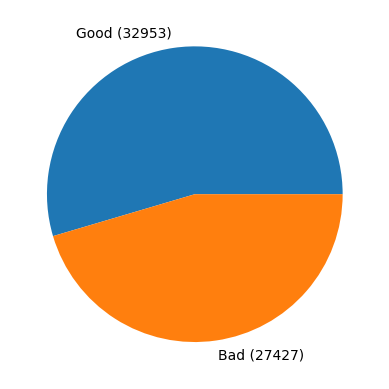

In [9]:
labels = raw_data.apply(calculate_video_success, axis=1, result_type="reduce", args=(THRESHOLD,))

amts = labels.value_counts()

plt.pie(amts, labels=[f"{'Good' if x == 1 else 'Bad'} ({amts.loc[x]})" for x in amts.keys()])

#### Models
Commonly, the Sequential API is used to train a model. However, due to the need for more than one input, the Functional API must be employed.

##### Image-Only Model

In [20]:
# Image Portion
img_input = Input((90, 120, 3), name="image_inputs")
x = Conv2D(32, 5, activation='relu', padding='same')(img_input)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x_out = Dropout(0.5)(x)
x_out = Dense(64, activation='relu')(x_out)
img_output = Dense(1, activation='sigmoid')(x_out)

img_model = Model(inputs=img_input, outputs=img_output, name="img_model")

img_model.summary()
plot_model(img_model, to_file='img_model.png', show_shapes=True, dpi=400)

Model: "img_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_inputs (InputLayer)   [(None, 90, 120, 3)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 120, 32)       2432      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 60, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 60, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 30, 128)       73

##### Text-Only Model

In [23]:
# Text Portion
text_input = Input(shape=(10,), dtype=tf.int32, name="text_inputs")
attention_mask = Input(shape=(10,), dtype=tf.int32, name="attention_masks")

transformer_output = bert_model(text_input, attention_mask=attention_mask)

# y = transformer_output.last_hidden_state[:, 0, :]
y = transformer_output.pooler_output

y = Dense(128, activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(64, activation='relu')(y)
y_out = Dropout(0.5)(y)
text_output = Dense(1, activation='sigmoid')(y_out)

text_model = Model(inputs=[text_input, attention_mask], outputs=text_output, name="text_model")

text_model.summary()
plot_model(text_model, to_file='text_model.png', show_shapes=True, dpi=400)

Model: "text_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_inputs (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 10)]                 0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['text_inputs[0][0]',         
 )                           ngAndCrossAttentions(last_   40         'attention_masks[0][0]']     
                             hidden_state=(None, 10, 76                                  

##### United Model

In [22]:
# United Model
z = Concatenate()([x, y])
z = Dropout(0.5)(z)
z = Dense(32, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)

united_model = Model(inputs=[img_input, text_input, attention_mask], outputs=z, name="united_model")

united_model.summary()
plot_model(united_model, to_file='united_model.png', show_shapes=True, dpi=400)

Model: "united_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_inputs (InputLayer)   [(None, 90, 120, 3)]         0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 90, 120, 32)          2432      ['image_inputs[0][0]']        
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 45, 60, 32)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 45, 60, 64)           18496     ['max_pooling2d_3[0

#### Generators
To lower memory usage, the dataset needs to be batched. This is done through the use of generators.

##### Thumbnail Data Generator
This generator is for the image-only model

In [13]:
class ThumbnailDataGenerator(Sequence):

	def __init__(self, 
			  filedir : str, 
			  list_IDs : pd.Series, 
			  labels : pd.Series, 
			  rescale : float=255.0, 
			  filetype : str="jpg", 
			  batch_size : int=32, 
			  dim : tuple[int, int]=(90, 120), 
			  shuffle=True
		):
		'''
		Data Generator Initialization Function 
		'''
		# File Location & Info
		self.filedir = filedir
		self.filetype = filetype

		# Image Settings
		self.dim = dim
		self.rescale = rescale

		# Batching
		self.batch_size = batch_size
		self.shuffle = shuffle

		# Datasets
		self.labels = labels
		self.list_IDs = list_IDs

		self.on_epoch_end()

	def on_epoch_end(self):
		'''
		Updates indexes after each epoch
		'''
		self.indexes = np.arange(len(self.list_IDs))

		# Randomize if Shuffle
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __data_generation(self, list_IDs_temp):
		'''
		Generates data containing batch_size samples
		'''
		# Initialization
		X = np.empty((self.batch_size, *self.dim, 3))
		y = np.empty((self.batch_size), dtype=float)

		# Generate data
		for i, ID in enumerate(list_IDs_temp):
			# Store sample
			X[i,] = Image.open(f'{self.filedir}/{ID}.{self.filetype}').convert("RGB")

			# Store class
			y[i] = self.labels[ID]

		# Rescale
		X /= self.rescale

		return X, y
	
	def __len__(self):
		'''
		Denotes the number of batches per epoch
		'''
		return int(np.floor(len(self.list_IDs) / self.batch_size))
	
	def __getitem__(self, index):
		'''
		Generate one batch of data
		'''
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

		# Find list of IDs
		list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

		# Generate data
		return self.__data_generation(list_IDs_temp)

##### Thumbnail and Title Data Generator
The following generator is meant to handle both images and text inputs.

In [14]:
class ThumbnailTitleDataGenerator(Sequence):

	def __init__(self, 
			  filedir : str, 
			  list_IDs : pd.Series, 
			  texts : pd.Series, 
			  labels : pd.Series, 
			  rescale : float=255.0, 
			  filetype : str="jpg", 
			  batch_size : int=32, 
			  img_dim : tuple[int, int]=(90, 120), 
			  text_dim : int=10, 
			  tokenizer : BertTokenizer=None,
			  img_input_name : str="image_inputs",
			  text_input_name : str="text_inputs",
			  attention_input_name : str="attention_masks",
			  shuffle=True
		):
		'''
		Data Generator Initialization Function 
		'''
		# File Location & Info
		self.filedir = filedir
		self.filetype = filetype

		# Dimensions
		self.img_dim = img_dim
		self.text_dim = text_dim
		self.rescale = rescale

		# Batching
		self.batch_size = batch_size
		self.shuffle = shuffle

		# Datasets
		self.labels = labels
		self.list_IDs = list_IDs
		self.texts = texts
		self.tokenizer = tokenizer

		# Input Names
		self.img_input_name = img_input_name
		self.text_input_name = text_input_name
		self.attention_input_name = attention_input_name

		self.on_epoch_end()

	def on_epoch_end(self):
		'''
		Updates indexes after each epoch
		'''
		self.indexes = np.arange(len(self.list_IDs))

		# Randomize if Shuffle
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __data_generation(self, list_IDs_temp : list[str]):
		'''
		Generates data containing batch_size samples
		'''
		# Initialization
		X_IMG = np.empty((self.batch_size, *self.img_dim, 3))
		X_TEXT = np.empty((self.batch_size, self.text_dim))
		X_ATTENTION = np.empty((self.batch_size, self.text_dim))
		y = np.empty((self.batch_size), dtype=float)

		# Generate data
		temp_titles : list[str] = [None] * self.batch_size
		for i, ID in enumerate(list_IDs_temp):
			# Store sample
			X_IMG[i,] = Image.open(f'{self.filedir}/{ID}.{self.filetype}').convert("RGB")

			# Process title
			temp_titles[i] = self.texts[ID]

			# Store class
			y[i] = self.labels[ID]

		# Rescale
		X_IMG /= self.rescale

		# Encode Text
		encoded_text = self.tokenizer(temp_titles, padding=True, truncation=True, max_length=self.text_dim)
		X_TEXT[:,:] = encoded_text["input_ids"]
		X_ATTENTION[:,:] = encoded_text["attention_mask"]

		# Unify Inputs
		X = {
			self.img_input_name: X_IMG,
			self.text_input_name: X_TEXT,
			self.attention_input_name: X_ATTENTION
		}

		return X, y
	
	def __len__(self):
		'''
		Denotes the number of batches per epoch
		'''
		return int(np.floor(len(self.list_IDs) / self.batch_size))
	
	def __getitem__(self, index):
		'''
		Generate one batch of data
		'''
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

		# Find list of IDs
		list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

		# Generate data
		return self.__data_generation(list_IDs_temp)

#### Training
Using k-fold cross validation, we can judge the accuarcy of this models. The models will undergo a k-fold cross validation.

##### Image-Only Training

In [ ]:
# Image Model
kf = KFold(n_folds)

img_validation_accuracy = []
img_validation_loss = []

fold_var = 1
for train, val in kf.split(thumbnail_ids, labels):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	img_model = Model(inputs=img_input, outputs=img_output, name="img_model")
	img_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/img-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
	early_stop = EarlyStopping(monitor='val_loss', patience=3)

	# Generator
	tbdg_train = ThumbnailDataGenerator(dirpath, thumbnail_ids.iloc[train], labels.iloc[train], batch_size=batch_size)
	tbdg_validate = ThumbnailDataGenerator(dirpath, thumbnail_ids.iloc[val], labels.iloc[val], batch_size=batch_size)

	# Fit
	history = img_model.fit(x=tbdg_train, validation_data=tbdg_validate, callbacks=[checkpoint, early_stop], epochs=epochs)

	# Grab Results
	img_model.load_weights(f"{modeldir}/img-model_{fold_var}.h5")
	
	results = img_model.evaluate(x=tbdg_validate)
	results = dict(zip(img_model.metrics_names, results))
	
	img_validation_accuracy.append(results['accuracy'])
	img_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/10


I0000 00:00:1732766721.888762     805 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1732766724.803791     804 service.cc:148] XLA service 0x7f1700f09a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732766724.804151     804 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-27 23:05:24.815802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732766724.977440     804 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1609/1610 [============================>.] - ETA: 0s - loss: 0.6397 - accuracy: 0.6285 - precision: 0.6229 - recall: 0.8064
Epoch 1: val_accuracy improved from -inf to 0.68682, saving model to models/img-model_1.h5
1610/1610 [==============================] - 52s 29ms/step - loss: 0.6398 - accuracy: 0.6286 - precision: 0.6229 - recall: 0.8065 - val_loss: 0.5840 - val_accuracy: 0.6868 - val_precision: 0.6825 - val_recall: 0.8037
Epoch 2/10
   1/1610 [..............................] - ETA: 1:20 - loss: 0.5647 - accuracy: 0.7000 - precision: 0.6842 - recall: 0.8125

/home/chairmanpooh/YT-ML/.venv/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1610/1610 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.6993 - precision: 0.7037 - recall: 0.7739
Epoch 2: val_accuracy improved from 0.68682 to 0.70887, saving model to models/img-model_1.h5
1610/1610 [==============================] - 29s 18ms/step - loss: 0.5733 - accuracy: 0.6993 - precision: 0.7037 - recall: 0.7739 - val_loss: 0.5558 - val_accuracy: 0.7089 - val_precision: 0.7026 - val_recall: 0.8159
Epoch 3/10
1607/1610 [============================>.] - ETA: 0s - loss: 0.5349 - accuracy: 0.7268 - precision: 0.7346 - recall: 0.7803
Epoch 3: val_accuracy improved from 0.70887 to 0.72421, saving model to models/img-model_1.h5
1610/1610 [==============================] - 29s 18ms/step - loss: 0.5349 - accuracy: 0.7268 - precision: 0.7347 - recall: 0.7803 - val_loss: 0.5400 - val_accuracy: 0.7242 - val_precision: 0.7199 - val_recall: 0.8159
Epoch 4/10
1610/1610 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.7494 - precision: 0.7587 -

##### Text-Only Training

In [ ]:
# Text Model
kf = KFold(n_folds)

text_validation_accuracy = []
text_validation_loss = []

fold_var = 1
for train, val in kf.split(input_texts["input_ids"], labels):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	text_model = Model(inputs=[text_input, attention_mask], outputs=text_output, name="text_model")
	text_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/text-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
	early_stop = EarlyStopping(monitor='val_loss', patience=3)

	# Train / Validation
	trainset = {
		"text_inputs": tf.gather(input_texts["input_ids"], indices=train), 
		"attention_masks": tf.gather(input_texts["attention_mask"], indices=train)
	}
	testset = {
		"text_inputs": tf.gather(input_texts["input_ids"], indices=val), 
		"attention_masks": tf.gather(input_texts["attention_mask"], indices=val)
	}

	# Fit
	history = text_model.fit(x=trainset, y=labels.iloc[train], validation_data=(testset, labels.iloc[val]), callbacks=[checkpoint, early_stop], epochs=epochs, batch_size=32)

	# Grab Results
	text_model.load_weights(f"{modeldir}/text-model_{fold_var}.h5")
	
	results = text_model.evaluate(x=testset, y=labels.iloc[val])
	results = dict(zip(text_model.metrics_names, results))
	
	text_validation_accuracy.append(results['accuracy'])
	text_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/10
1510/1510 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5405
Epoch 1: val_accuracy improved from -inf to 0.54960, saving model to models/text-model_1.h5


/home/chairmanpooh/YT-ML/.venv/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1510/1510 [==============================] - 146s 89ms/step - loss: 0.6931 - accuracy: 0.5405 - val_loss: 0.6863 - val_accuracy: 0.5496
Epoch 2/10
1510/1510 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5447
Epoch 2: val_accuracy did not improve from 0.54960
1510/1510 [==============================] - 133s 88ms/step - loss: 0.6897 - accuracy: 0.5447 - val_loss: 0.6885 - val_accuracy: 0.5496
Epoch 3/10
1510/1510 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5443
Epoch 3: val_accuracy did not improve from 0.54960
1510/1510 [==============================] - 131s 87ms/step - loss: 0.6878 - accuracy: 0.5443 - val_loss: 0.6832 - val_accuracy: 0.5496
Epoch 4/10
1510/1510 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5444
Epoch 4: val_accuracy did not improve from 0.54960
1510/1510 [==============================] - 132s 87ms/step - loss: 0.6862 - accuracy: 0.5444 - val_loss: 0.6865 - val_accuracy: 0.5496
Epoch 5/1

##### United Training

In [ ]:
# United Model
kf = KFold(n_folds)

united_validation_accuracy = []
united_validation_loss = []

fold_var = 1
for train, val in kf.split(thumbnail_ids, labels):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	united_model = Model(inputs=[img_input, text_input, attention_mask], outputs=z, name="united_model")
	united_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/complete-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

	# Generator
	tbtdg_train = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[train], raw_data["title"].iloc[train], labels.iloc[train], batch_size=batch_size, tokenizer=bert_tokenizer)
	tbtdg_validate = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[val], raw_data["title"].iloc[val], labels.iloc[val], batch_size=batch_size, tokenizer=bert_tokenizer)

	# Fit
	history = united_model.fit(x=tbtdg_train, validation_data=tbtdg_validate, callbacks=[checkpoint], epochs=epochs)

	# Grab Results
	united_model.load_weights(f"{modeldir}/complete-model_{fold_var}.h5")
	
	results = united_model.evaluate(x=tbtdg_validate)
	results = dict(zip(united_model.metrics_names, results))
	
	united_validation_accuracy.append(results['accuracy'])
	united_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/10
1610/1610 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.8894 - precision: 0.7771 - recall: 0.4321
Epoch 1: val_accuracy improved from -inf to 0.89917, saving model to models\complete-model_1.h5


d:\OneDrive\OneDrive - University of Waterloo\School\Courses\4A\MSE 446\Project\YT-ML\.venv\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1610/1610 [==============================] - 700s 428ms/step - loss: 0.2900 - accuracy: 0.8894 - precision: 0.7771 - recall: 0.4321 - val_loss: 0.2503 - val_accuracy: 0.8992 - val_precision: 0.9027 - val_recall: 0.4592
Epoch 2/10
1610/1610 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.9019 - precision: 0.8232 - recall: 0.4921
Epoch 2: val_accuracy improved from 0.89917 to 0.90464, saving model to models\complete-model_1.h5
1610/1610 [==============================] - 563s 350ms/step - loss: 0.2584 - accuracy: 0.9019 - precision: 0.8232 - recall: 0.4921 - val_loss: 0.2540 - val_accuracy: 0.9046 - val_precision: 0.8779 - val_recall: 0.5131
Epoch 3/10
1610/1610 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9054 - precision: 0.8328 - recall: 0.5109
Epoch 3: val_accuracy did not improve from 0.90464
1610/1610 [==============================] - 556s 345ms/step - loss: 0.2430 - accuracy: 0.9054 - precision: 0.8328 - recall: 0.5109 - val_loss

##### Final Training
Once all the models have been trained and analysised with k-fold cross validation, the final model will be trained with all the data. It will then be tested with new data from the YouTube API.

In [181]:
# Clear Keras
clear_session()

# Make image model for testing
united_model = Model(inputs=[img_input, text_input, attention_mask], outputs=z, name="final_united_model")
united_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Callback Saving
checkpoint = ModelCheckpoint(f"{modeldir}/final-complete-model.h5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')

# Generator
tbtdg_train = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids, raw_data["title"], labels, batch_size=batch_size, tokenizer=bert_tokenizer)

# Fit
history = united_model.fit(x=tbtdg_train, callbacks=[checkpoint], epochs=epochs)

Epoch 1/10
2012/2012 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9021 - precision: 0.8293 - recall: 0.4987
Epoch 1: accuracy improved from -inf to 0.90210, saving model to models\final-complete-model.h5
2012/2012 [==============================] - 921s 452ms/step - loss: 0.2565 - accuracy: 0.9021 - precision: 0.8293 - recall: 0.4987
Epoch 2/10
2012/2012 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.9097 - precision: 0.8545 - recall: 0.5342
Epoch 2: accuracy improved from 0.90210 to 0.90974, saving model to models\final-complete-model.h5
2012/2012 [==============================] - 900s 447ms/step - loss: 0.2358 - accuracy: 0.9097 - precision: 0.8545 - recall: 0.5342
Epoch 3/10
2012/2012 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9134 - precision: 0.8665 - recall: 0.5502
Epoch 3: accuracy improved from 0.90974 to 0.91337, saving model to models\final-complete-model.h5
2012/2012 [==========================

#### Testing with New Data
Only a final model has been trained, it must be tested with new data. This can be collected from the YouTube API.